In [ ]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
'''
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
!git clone https://github.com/intsoo/RayTracing_MSSIM.git /gdrive/My` Drive/MSSIM
'''

Mounted at /gdrive
fatal: could not create work tree dir '/gdrive/MSSIM': Operation not supported


# 1. Generate a 2D Gaussian Filter for MSSIM
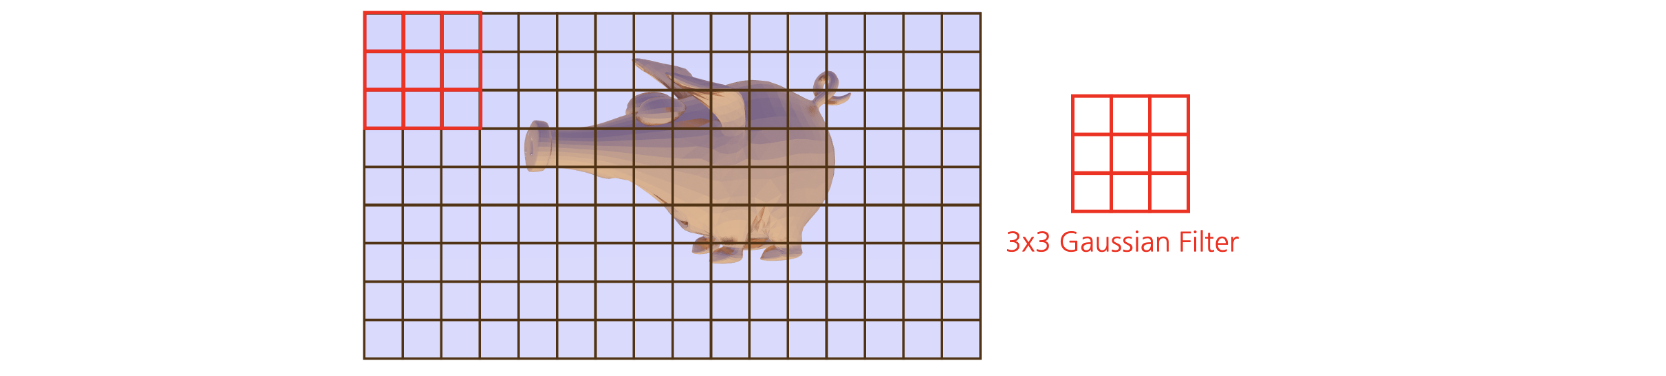

In [ ]:
# guassian(): generates a Tensor from a Gaussian distribution (size: window_size)
def gaussian(window_size, sigma):
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

In [ ]:
# Check if gaussian() works fine
gauss_dis = gaussian(11, 1.5)
print("Distribution: ", gauss_dis)
print("Sum of Gauss Distribution:", torch.sum(gauss_dis))  # sum of all values should be 1

Distribution:  tensor([0.0010, 0.0076, 0.0360, 0.1094, 0.2130, 0.2660, 0.2130, 0.1094, 0.0360,
        0.0076, 0.0010])
Sum of Gauss Distribution: tensor(1.)


In [ ]:
# create_window(): creates a 2D Gaussian filter with the Gaussian Tensor
def create_window(window_size, channel=1):
    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Convert the 1D tensor to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

In [ ]:
window = create_window(11, 3)
print("Shape of gaussian window:", window.shape)

Shape of gaussian window: torch.Size([3, 1, 11, 11])


# 2. Compute the MSSIM of two images
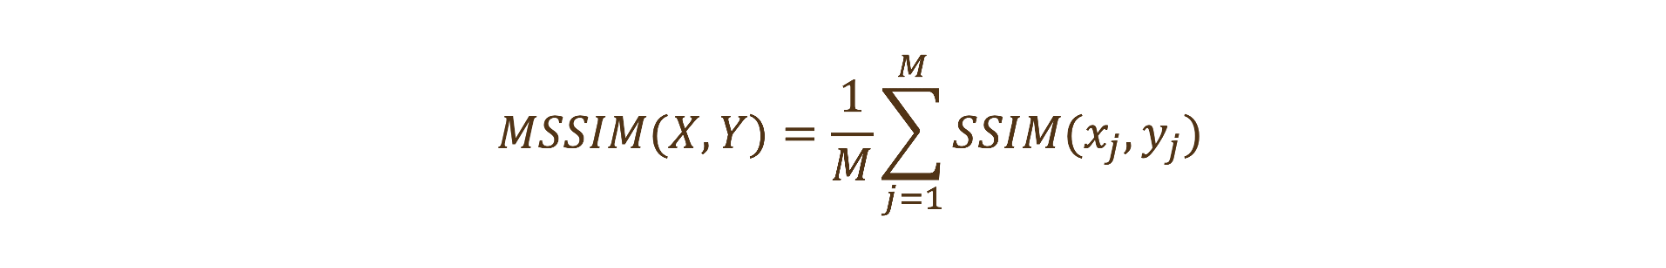
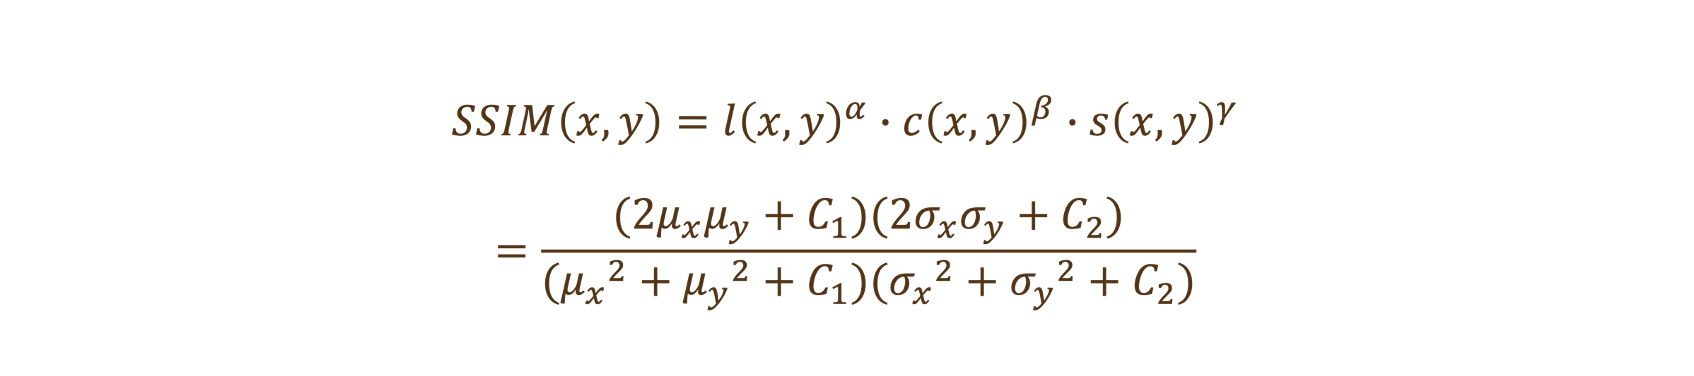

In [ ]:
# mssim(): computes a MSSIM value of two images
def mssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # If a window is not provided, generate one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # Calculate local mu(luminance) parameters using Gaussian filter
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)  # mu of image 1
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)  # mu of image 2
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # Calculate local sigma(Contrast) square parameters
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    # parameters of SSIM formula
    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    # Compute the MSSIM score
    mssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = mssim_score.mean() 
    else: 
        ret = mssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

# Load images and compute the MSSIM score.

In [ ]:
# helper function to load images

# Image Size
img_width = 1920
img_height = 1080

load_images = lambda x: np.asarray(Image.open(x).resize((img_width, img_height)))

# helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display_imgs(): displays images
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (img_width, img_height))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

In [63]:
# Load Images
#img1 = load_images("RayTracing_MSSIM/img/BFP_solved_1920_s1_d50.jpg")
img_BFP_X = load_images("img/BFP_dielectricX.jpg")
img_BFP_X_name = "Low Precision (Dielectric not Fixed)"

img_BFP_O = load_images("img/BFP_dielectricO.jpg")
img_BFP_O_name = "Low Precision (Dielectric Fixed)"

img_FP32 = load_images("img/FP32.jpg")
img_FP32_name = "FP32"

noise = np.random.randint(0, 255, (img_height, img_width, 3)).astype(np.float32)
img_FP32_noisy = img_FP32 + noise 
img_FP32_noisy_name = "FP32 with Noise"

# Display images
print("1. " + img_BFP_X_name + "\n")
display_imgs(img_BFP_X)

print("2. " + img_BFP_O_name + "\n")
display_imgs(img_BFP_O)

print("3. " + img_FP32_name + "\n")
display_imgs(img_FP32)

print("4. " + img_FP32_noisy_name + "\n")
display_imgs(img_FP32_noisy)




Output hidden; open in https://colab.research.google.com to view.

In [65]:
# Compare FP32 and BFP(dielectric not fixed)
_img1 = tensorify(img_BFP_X)
_img2 = tensorify(img_FP32)
mssim_score1 = mssim(_img1, _img2, val_range=255)
print("[MSSIM] " + img_BFP_X_name + " vs " + img_FP32_name + "\n: ", mssim_score1)

[MSSIM] Low Precision (Dielectric not Fixed) vs FP32
:  tensor(0.4026)


In [66]:
# Compare FP32 and BFP(dielectric fixed)
_img1 = tensorify(img_BFP_O)
_img2 = tensorify(img_FP32)
mssim_score2 = mssim(_img1, _img2, val_range=255)
print("[MSSIM] " + img_BFP_O_name + " vs " + img_FP32_name + "\n: ", mssim_score2)

[MSSIM] Low Precision (Dielectric Fixed) vs FP32
:  tensor(0.4246)


In [67]:
# Compare FP32 and FP32 with noise
_img1 = tensorify(img_FP32_noisy)
_img2 = tensorify(img_FP32)
mssim_score3 = mssim(_img1, _img2, val_range=255)
print("[MSSIM] " + img_FP32_noisy_name + " vs " + img_FP32_name + "\n: ", mssim_score3)

[MSSIM] FP32 with Noise vs FP32
:  tensor(0.0877)


In [68]:
# Compare FP32 and FP32 (same image)
_img1 = tensorify(img_FP32)
_img2 = tensorify(img_FP32)
mssim_score4 = mssim(_img1, _img2, val_range=255)
print("[MSSIM] " + img_FP32_name + " vs " + img_FP32_name + "\n: ", mssim_score4)

[MSSIM] FP32 vs FP32
:  tensor(1.)
